# 通し課題模範解答 回帰編 DAY 3
- kaggle の kickstarter project に関して，usd_pledged_real を予測するモデルを作成する
    - https://www.kaggle.com/kemical/kickstarter-projects?select=ks-projects-201801.csv
- DAY 3 では，以下を行う
    - 特徴選択
        - フィルタ法
        - ラッパー法
        - 埋め込み法
    - 木モデルの利用
        - 決定木
        - ランダムフォレスト
        - アダブースト
    - ニューラルネットワークの利用

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

In [3]:
df = pd.read_csv('../data/df_regression.csv', index_col='ID')
df.head()

,usd_pledged_real,usd_goal_real,period,log_usd_goal,log_usd_pledged,n_words,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
ID,,,,,,,,,,,,,,,,,,,,,
1000002330,0.0,1533.95,58,3.185811,-5.000000,6,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1000003930,2421.0,30000.00,59,4.477121,3.383995,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1000004038,220.0,45000.00,44,4.653213,2.342423,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1000007540,1.0,5000.00,29,3.698970,0.000004,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1000011046,1283.0,19500.00,55,4.290035,3.108227,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
X = df.drop(columns=['log_usd_pledged', 'usd_pledged_real'])
y = df['usd_pledged_real']
log_y = df['log_usd_pledged']

X_train, X_test, y_train, y_test, log_y_train, log_y_test = train_test_split(X, y, log_y, test_size=0.3, random_state=1234)

In [5]:
std = StandardScaler()
X_train.loc[:, ['log_usd_goal', 'period']] = std.fit_transform(X_train.loc[:, ['log_usd_goal', 'period']])
X_test.loc[:, ['log_usd_goal', 'period']] = std.transform(X_test.loc[:, ['log_usd_goal', 'period']])

/Users/Mayu.T/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Mayu.T/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/Mayu.T/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/Mayu.T/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

## 特徴選択
### フィルタ法
- 相関係数による特徴選択を検討する

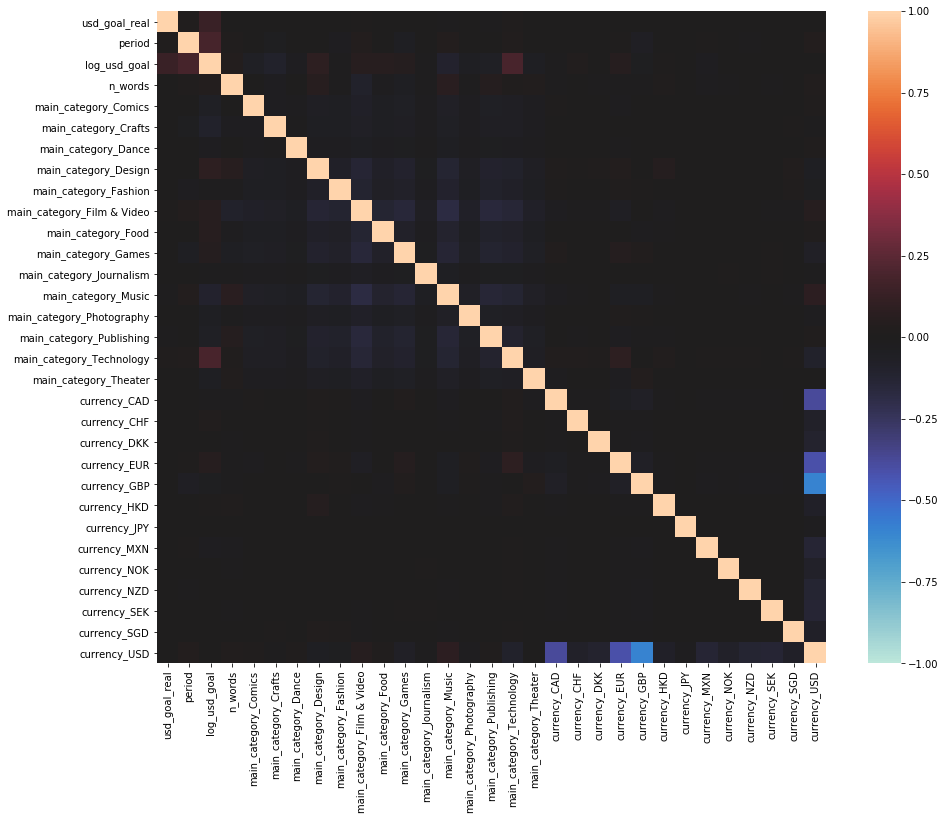

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
sns.heatmap(X_train.corr(), center=0, vmax=1, vmin=-1, ax=ax)

In [6]:
# 相関係数の絶対値が 0.3 以上 1.0 未満であるものを列挙
X_corr = X_train.corr().abs()
X_corr = X_corr.unstack()
X_corr = X_corr.sort_values(kind="quicksort")
X_corr[(0.2 < X_corr) & (X_corr < 1)]

currency_CAD  currency_USD    0.382326
currency_USD  currency_CAD    0.382326
              currency_EUR    0.413907
currency_EUR  currency_USD    0.413907
currency_USD  currency_GBP    0.592161
currency_GBP  currency_USD    0.592161
dtype: float64

最大で相関係数の絶対値が 0.6 程度であるため高いとは言えず，変数の削除の必要性はないと判断できる

### ラッパー法
- ステップワイズ法による特徴選択を行う

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)

In [8]:
lr_reg = LinearRegression()
rfecv = RFECV(lr_reg, cv=kf, scoring='neg_mean_squared_error', verbose=3)
rfecv.fit(X_train, y_train)

Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features

RFECV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
      estimator=LinearRegression(), scoring='neg_mean_squared_error',
      verbose=3)

In [9]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [10]:
y_pred = rfecv.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae:.3}')
print(f'MSE: {mse:.3}')
print(f'RMSE: {rmse:.3}')

MAE: 1.4e+04
MSE: 4.9e+09
RMSE: 7e+04


すべての変数が選ばれてしまった．
対数領域で試してみる．

In [11]:
lr_reg = LinearRegression()
rfecv = RFECV(lr_reg, cv=kf, scoring='neg_mean_squared_error', verbose=3)
rfecv.fit(X_train, log_y_train)

Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features

RFECV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
      estimator=LinearRegression(), scoring='neg_mean_squared_error',
      verbose=3)

In [12]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [13]:
log_y_pred = rfecv.predict(X_test)

mae_log = mean_absolute_error(log_y_test, log_y_pred)
mse_log = mean_squared_error(log_y_test, log_y_pred)
rmse_log = np.sqrt(mse_log)

mae = mean_absolute_error(10**log_y_test, 10**log_y_pred)
mse = mean_squared_error(10**log_y_test, 10**log_y_pred)
rmse = np.sqrt(mse)

print(f'対数領域 MAE: {mae_log:.3}')
print(f'対数領域 MSE: {mse_log:.3}')
print(f'対数領域 RMSE: {rmse_log:.3}')

print(f'MAE: {mae:.3}')
print(f'MSE: {mse:.3}')
print(f'RMSE: {rmse:.3}')

対数領域 MAE: 2.04
対数領域 MSE: 8.01
対数領域 RMSE: 2.83
MAE: 8.71e+03
MSE: 5.14e+09
RMSE: 7.17e+04


すべての変数が選ばれてしまった．

### 埋め込み法
- L_1 正則化によって特徴選択を行う

In [14]:
lr_cv = LassoCV(normalize=True, cv=kf, max_iter=10000, random_state=1234, tol=1e-3, verbose=1)
sfm = SelectFromModel(lr_cv, threshold=1e-5)
sfm.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


SelectFromModel(estimator=LassoCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
                                  max_iter=10000, normalize=True,
                                  random_state=1234, tol=0.001, verbose=1),
                threshold=1e-05)

In [15]:
sfm.get_support()

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [16]:
X_train_l1 = X_train.loc[:, sfm.get_support()]
X_test_l1 = X_test.loc[:, sfm.get_support()]

In [17]:
lr_reg = LinearRegression()
lr_reg.fit(X_train_l1, y_train)
y_pred = lr_reg.predict(X_test_l1)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae:.3}')
print(f'MSE: {mse:.3}')
print(f'RMSE: {rmse:.3}')

MAE: 1.4e+04
MSE: 4.9e+09
RMSE: 7e+04


変数選択前と性能に変化なし．対数領域で試してみる．

In [18]:
lr_cv = LassoCV(normalize=True, cv=kf, max_iter=10000, random_state=1234, tol=1e-3, verbose=1)
sfm = SelectFromModel(lr_cv, threshold=1e-5)
sfm.fit(X_train, log_y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


SelectFromModel(estimator=LassoCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
                                  max_iter=10000, normalize=True,
                                  random_state=1234, tol=0.001, verbose=1),
                threshold=1e-05)

In [19]:
sfm.get_support()

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [20]:
X_train_l1 = X_train.loc[:, sfm.get_support()]
X_test_l1 = X_test.loc[:, sfm.get_support()]

In [21]:
lr_reg = LinearRegression()
lr_reg.fit(X_train_l1, log_y_train)
log_y_pred = lr_reg.predict(X_test_l1)

mae_log = mean_absolute_error(log_y_test, log_y_pred)
mse_log = mean_squared_error(log_y_test, log_y_pred)
rmse_log = np.sqrt(mse_log)

mae = mean_absolute_error(10**log_y_test, 10**log_y_pred)
mse = mean_squared_error(10**log_y_test, 10**log_y_pred)
rmse = np.sqrt(mse)

print(f'対数領域 MAE: {mae_log:.3}')
print(f'対数領域 MSE: {mse_log:.3}')
print(f'対数領域 RMSE: {rmse_log:.3}')

print(f'MAE: {mae:.3}')
print(f'MSE: {mse:.3}')
print(f'RMSE: {rmse:.3}')

対数領域 MAE: 2.04
対数領域 MSE: 8.02
対数領域 RMSE: 2.83
MAE: 8.71e+03
MSE: 5.14e+09
RMSE: 7.17e+04


精度に変化なし．

##  木モデルの利用
### 決定木
以下をチューニングしつつ学習
- max_depth: 木の深さの最大値
- min_samples_leaf: 1つのノードに許される最小サンプルサイズ

In [22]:
parameters = {'max_depth': range(10, 15), 'min_samples_leaf': range(1, 5)}

dtr = DecisionTreeRegressor(criterion='mse', random_state=1234)
grid = GridSearchCV(dtr, param_grid=parameters, 
                         cv=kf, 
                         scoring='neg_mean_squared_error', 
                         verbose=3) 

grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] max_depth=10, min_samples_leaf=1 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, min_samples_leaf=1, score=-6340889979.629, total=   0.8s
[CV] max_depth=10, min_samples_leaf=1 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=1, score=-16537565987.812, total=   0.9s
[CV] max_depth=10, min_samples_leaf=1 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=1, score=-14982835243.122, total=   0.8s
[CV] max_depth=10, min_samples_leaf=1 ................................
[CV]  max_depth=10, min_samples_leaf=1, score=-17787836076.654, total=   0.8s
[CV] max_depth=10, min_samples_leaf=1 ................................
[CV]  max_depth=10, min_samples_leaf=1, score=-17435899694.974, total=   0.8s
[CV] max_depth=10, min_samples_leaf=2 ................................
[CV]  max_depth=10, min_samples_leaf=2, score=-8957056024.900, total=   0.8s
[CV] max_depth=10, min_samples_leaf=2 ................................
[CV]  max_depth=10, min_samples_leaf=2, score=-16124993874.239, total=   0.8s
[CV] max_depth=10, min_samples_leaf=2 ................................
[CV]  max_depth=10, min_samples_leaf=2, score=-12706370778.319, total=   0.9s
[CV] max_depth=10, min_samples_leaf=2 ................................
[CV]  max_depth=10, min_samples_leaf=2, score=-14127739349.339, total=   0.8s
[CV] max_depth=10, min_sample

[CV]  max_depth=12, min_samples_leaf=4, score=-13137200088.825, total=   1.0s
[CV] max_depth=12, min_samples_leaf=4 ................................
[CV]  max_depth=12, min_samples_leaf=4, score=-8357323523.064, total=   1.0s
[CV] max_depth=13, min_samples_leaf=1 ................................
[CV]  max_depth=13, min_samples_leaf=1, score=-8056623806.328, total=   1.0s
[CV] max_depth=13, min_samples_leaf=1 ................................
[CV]  max_depth=13, min_samples_leaf=1, score=-17349506072.898, total=   1.1s
[CV] max_depth=13, min_samples_leaf=1 ................................
[CV]  max_depth=13, min_samples_leaf=1, score=-32929595494.927, total=   1.0s
[CV] max_depth=13, min_samples_leaf=1 ................................
[CV]  max_depth=13, min_samples_leaf=1, score=-18552421372.047, total=   1.0s
[CV] max_depth=13, min_samples_leaf=1 ................................
[CV]  max_depth=13, min_samples_leaf=1, score=-18370445678.369, total=   1.0s
[CV] max_depth=13, min_samples

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=1234),
             param_grid={'max_depth': range(10, 15),
                         'min_samples_leaf': range(1, 5)},
             scoring='neg_mean_squared_error', verbose=3)

In [23]:
y_pred = grid.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae:.3}')
print(f'MSE: {mse:.3}')
print(f'RMSE: {rmse:.3}')

MAE: 1.18e+04
MSE: 5.6e+09
RMSE: 7.48e+04


In [24]:
grid.best_estimator_

DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, random_state=1234)

線形モデルより性能は良くなった．対数領域で試してみる

In [25]:
dtr = DecisionTreeRegressor(criterion='mse', random_state=1234)
grid = GridSearchCV(dtr, param_grid=parameters, 
                         cv=kf, 
                         scoring='neg_mean_squared_error', 
                         verbose=3) 

grid.fit(X_train, log_y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] max_depth=10, min_samples_leaf=1 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... max_depth=10, min_samples_leaf=1, score=-7.929, total=   0.7s
[CV] max_depth=10, min_samples_leaf=1 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ... max_depth=10, min_samples_leaf=1, score=-7.921, total=   0.8s
[CV] max_depth=10, min_samples_leaf=1 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV] ... max_depth=10, min_samples_leaf=1, score=-7.919, total=   0.8s
[CV] max_depth=10, min_samples_leaf=1 ................................
[CV] ... max_depth=10, min_samples_leaf=1, score=-7.975, total=   0.8s
[CV] max_depth=10, min_samples_leaf=1 ................................
[CV] ... max_depth=10, min_samples_leaf=1, score=-7.930, total=   0.8s
[CV] max_depth=10, min_samples_leaf=2 ................................
[CV] ... max_depth=10, min_samples_leaf=2, score=-7.913, total=   0.8s
[CV] max_depth=10, min_samples_leaf=2 ................................
[CV] ... max_depth=10, min_samples_leaf=2, score=-7.915, total=   0.8s
[CV] max_depth=10, min_samples_leaf=2 ................................
[CV] ... max_depth=10, min_samples_leaf=2, score=-7.905, total=   0.8s
[CV] max_depth=10, min_samples_leaf=2 ................................
[CV] ... max_depth=10, min_samples_leaf=2, score=-7.969, total=   0.8s
[CV] max_depth=10, min_samples_leaf=2 ................................
[CV] .

[CV] ... max_depth=13, min_samples_leaf=1, score=-8.057, total=   0.9s
[CV] max_depth=13, min_samples_leaf=1 ................................
[CV] ... max_depth=13, min_samples_leaf=1, score=-8.081, total=   1.0s
[CV] max_depth=13, min_samples_leaf=1 ................................
[CV] ... max_depth=13, min_samples_leaf=1, score=-8.077, total=   0.9s
[CV] max_depth=13, min_samples_leaf=1 ................................
[CV] ... max_depth=13, min_samples_leaf=1, score=-8.116, total=   1.0s
[CV] max_depth=13, min_samples_leaf=1 ................................
[CV] ... max_depth=13, min_samples_leaf=1, score=-8.051, total=   1.0s
[CV] max_depth=13, min_samples_leaf=2 ................................
[CV] ... max_depth=13, min_samples_leaf=2, score=-8.036, total=   1.0s
[CV] max_depth=13, min_samples_leaf=2 ................................
[CV] ... max_depth=13, min_samples_leaf=2, score=-8.033, total=   1.0s
[CV] max_depth=13, min_samples_leaf=2 ................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=1234),
             param_grid={'max_depth': range(10, 15),
                         'min_samples_leaf': range(1, 5)},
             scoring='neg_mean_squared_error', verbose=3)

In [26]:
log_y_pred = grid.predict(X_test)

mae_log = mean_absolute_error(log_y_test, log_y_pred)
mse_log = mean_squared_error(log_y_test, log_y_pred)
rmse_log = np.sqrt(mse_log)

mae = mean_absolute_error(10**log_y_test, 10**log_y_pred)
mse = mean_squared_error(10**log_y_test, 10**log_y_pred)
rmse = np.sqrt(mse)

print(f'対数領域 MAE: {mae_log:.3}')
print(f'対数領域 MSE: {mse_log:.3}')
print(f'対数領域 RMSE: {rmse_log:.3}')

print(f'MAE: {mae:.3}')
print(f'MSE: {mse:.3}')
print(f'RMSE: {rmse:.3}')

対数領域 MAE: 2.01
対数領域 MSE: 7.86
対数領域 RMSE: 2.8
MAE: 8.62e+03
MSE: 5.06e+09
RMSE: 7.12e+04


対数変換前にくらべてさらに性能は良くなった．
右に歪んだ目的変数を持つデータに対して，目的変数の対数変換は有用である．以後，対数領域で学習を実行する．

### ランダムフォレスト
以下をチューニングしつつ学習．実行に30分ほどかかるので注意する
- n_estimators: 弱学習器の数

In [27]:
parameters = {'n_estimators': range(50, 100, 10)}

rfr = RandomForestRegressor(criterion='mse', random_state=1234)
grid = GridSearchCV(rfr, param_grid=parameters, 
                         cv=kf, 
                         scoring='neg_mean_squared_error', 
                         verbose=3) 

grid.fit(X_train, log_y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... n_estimators=50, score=-8.881, total=  48.1s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.1s remaining:    0.0s


[CV] .................... n_estimators=50, score=-8.850, total=  48.6s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] .................... n_estimators=50, score=-8.878, total=  51.1s
[CV] n_estimators=50 .................................................
[CV] .................... n_estimators=50, score=-8.929, total=  48.0s
[CV] n_estimators=50 .................................................
[CV] .................... n_estimators=50, score=-8.830, total=  52.4s
[CV] n_estimators=60 .................................................
[CV] .................... n_estimators=60, score=-8.872, total=  57.6s
[CV] n_estimators=60 .................................................
[CV] .................... n_estimators=60, score=-8.836, total=  58.3s
[CV] n_estimators=60 .................................................
[CV] .................... n_estimators=60, score=-8.863, total=  56.9s
[CV] n_estimators=60 .................................................
[CV] .................... n_estimators=60, score=-8.914, total=  57.4s
[CV] n_estimators=60 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 27.5min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=RandomForestRegressor(random_state=1234),
             param_grid={'n_estimators': range(50, 100, 10)},
             scoring='neg_mean_squared_error', verbose=3)

In [28]:
log_y_pred = grid.predict(X_test)

mae_log = mean_absolute_error(log_y_test, log_y_pred)
mse_log = mean_squared_error(log_y_test, log_y_pred)
rmse_log = np.sqrt(mse_log)

mae = mean_absolute_error(10**log_y_test, 10**log_y_pred)
mse = mean_squared_error(10**log_y_test, 10**log_y_pred)
rmse = np.sqrt(mse)

print(f'対数領域 MAE: {mae_log:.3}')
print(f'対数領域 MSE: {mse_log:.3}')
print(f'対数領域 RMSE: {rmse_log:.3}')

print(f'MAE: {mae:.3}')
print(f'MSE: {mse:.3}')
print(f'RMSE: {rmse:.3}')

対数領域 MAE: 2.13
対数領域 MSE: 8.8
対数領域 RMSE: 2.97
MAE: 8.67e+03
MSE: 5.03e+09
RMSE: 7.09e+04


In [29]:
grid.best_estimator_

RandomForestRegressor(n_estimators=90, random_state=1234)

- 決定木と性能は大差ない
- CV のスコアを見る限り，`n_estimators`に対してロバストであると推察できる

### アダブースト
決定木を弱学習器としたアダブーストを，以下をチューニングしながら学習
- n_estimators: 弱学習器の数

In [30]:
parameters = {'n_estimators': range(50, 100, 10)}

abr = AdaBoostRegressor(random_state=1234)
grid = GridSearchCV(estimator=abr, param_grid=parameters, 
                         cv=kf, 
                         scoring='neg_mean_squared_error', 
                         verbose=3) 

grid.fit(X_train, log_y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... n_estimators=50, score=-8.524, total=   5.9s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV] .................... n_estimators=50, score=-8.576, total=   5.9s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s


[CV] .................... n_estimators=50, score=-8.547, total=   5.8s
[CV] n_estimators=50 .................................................
[CV] .................... n_estimators=50, score=-8.635, total=   6.5s
[CV] n_estimators=50 .................................................
[CV] .................... n_estimators=50, score=-8.590, total=   4.6s
[CV] n_estimators=60 .................................................
[CV] .................... n_estimators=60, score=-8.524, total=   5.9s
[CV] n_estimators=60 .................................................
[CV] .................... n_estimators=60, score=-8.576, total=   5.9s
[CV] n_estimators=60 .................................................
[CV] .................... n_estimators=60, score=-8.547, total=   5.9s
[CV] n_estimators=60 .................................................
[CV] .................... n_estimators=60, score=-8.635, total=   6.5s
[CV] n_estimators=60 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.4min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=AdaBoostRegressor(random_state=1234),
             param_grid={'n_estimators': range(50, 100, 10)},
             scoring='neg_mean_squared_error', verbose=3)

In [31]:
log_y_pred = grid.predict(X_test)

mae_log = mean_absolute_error(log_y_test, log_y_pred)
mse_log = mean_squared_error(log_y_test, log_y_pred)
rmse_log = np.sqrt(mse_log)

mae = mean_absolute_error(10**log_y_test, 10**log_y_pred)
mse = mean_squared_error(10**log_y_test, 10**log_y_pred)
rmse = np.sqrt(mse)

print(f'対数領域 MAE: {mae_log:.3}')
print(f'対数領域 MSE: {mse_log:.3}')
print(f'対数領域 RMSE: {rmse_log:.3}')

print(f'MAE: {mae:.3}')
print(f'MSE: {mse:.3}')
print(f'RMSE: {rmse:.3}')

対数領域 MAE: 2.38
対数領域 MSE: 8.53
対数領域 RMSE: 2.92
MAE: 8.75e+03
MSE: 5.09e+09
RMSE: 7.13e+04


In [32]:
grid.best_estimator_

AdaBoostRegressor(random_state=1234)

決定木・ランダムフォレストと大差ない性能である

## ニューラルネットワークの利用
- FutureWarning は無視して良い

In [33]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError

/Users/mizoguchi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mizoguchi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mizoguchi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/mizoguchi/anaconda3/lib/python3.7/site-packages/tensorflow/pyth

In [34]:
model = Sequential()
model.add(Input(shape=(len(X_train.columns),)))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))

model.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=[RootMeanSquaredError(), MeanAbsoluteError()],
    
)

WARNING - From /Users/mizoguchi/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [35]:
history = model.fit(
    X_train,
    log_y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_test, log_y_test),
)

Train on 265055 samples, validate on 113595 samples
Epoch 1/10
265055/265055 [==============================] - 7s 25us/sample - loss: 10.0930 - root_mean_squared_error: 2.9341 - mean_absolute_error: 2.1527 - val_loss: 9.2686 - val_root_mean_squared_error: 2.9585 - val_mean_absolute_error: 2.0150
Epoch 2/10
265055/265055 [==============================] - 6s 23us/sample - loss: 8.7150 - root_mean_squared_error: 2.9126 - mean_absolute_error: 2.1082 - val_loss: 8.8314 - val_root_mean_squared_error: 2.9556 - val_mean_absolute_error: 2.0279
Epoch 3/10
265055/265055 [==============================] - 6s 23us/sample - loss: 8.5559 - root_mean_squared_error: 2.9133 - mean_absolute_error: 2.1078 - val_loss: 8.7257 - val_root_mean_squared_error: 2.9463 - val_mean_absolute_error: 1.9449
Epoch 4/10
265055/265055 [==============================] - 6s 23us/sample - loss: 8.5264 - root_mean_squared_error: 2.9125 - mean_absolute_error: 2.1078 - val_loss: 8.6711 - val_root_mean_squared_error: 2.9374 -

ランダムフォレスト などと同等の性能が得られた